In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy import stats
import scipy as sp

from collections import defaultdict
import community
import argparse
import gzip

import sys
%matplotlib inline

# Analyzing Causal Structure in Networks

# 1. Effective Information in Networks

## 1.0 Create Transition-Probability Matrices

In [2]:
def define_TPM(matType="copycopy", asnx=False, noise=0.0):
    """Defines a transition probability matrix, default is TPM from two deterministic copy gates."""
    if matType=="copycopy":
        tpm = np.array([[1.0,0,0,0],
                        [0,0,1.0,0],
                        [0,1.0,0,0],
                        [0,0,0,1.0]])
    if matType=="andand":
        tpm = np.array([[1.0,0,0,0],
                        [1.0,0,0,0],
                        [1.0,0,0,0],
                        [0,0,0,1.0]])
        
    if matType=="oror":
        tpm = np.array([[1.0,0,0,0],
                        [0,0,0,1.0],
                        [0,0,0,1.0],
                        [0,0,0,1.0]])

    if matType=="orcopy":
        tpm = np.array([[1.0,0,0,0],
                        [0,0,1.0,0],
                        [0,0,0,1.0],
                        [0,0,0,1.0]])

    if matType=="star":
        tpm = np.array([[1.0,0,0,0],
                        [1.0,0,0,0],
                        [1.0,0,0,0],
                        [1.0,0,0,0]])

    if noise > 0.0:
        tpm += noise
        rowsums = np.sum(tpm, 1)
        tpm = np.array([tpm[i]/rowsums[i] for i in range(len(tpm))])
        
    if asnx:
        G = nx.from_numpy_matrix(tpm, create_using=nx.DiGraph())
        return G
    
    return tpm

def add_noise(G, noise=0.01, return_G=False):
    if type(G)==np.ndarray:
        G = nx.from_numpy_matrix(G, create_using=nx.DiGraph())
    elif type(G)==nx.classes.graph.Graph:
        G = nx.DiGraph(G)
    
    A = nx.adjacency_matrix(G)
    A = A.toarray() 
    A = A + noise
    rowsums = np.sum(A, 1)
    A = np.array([A[i]/rowsums[i] for i in range(len(A))])
    if return_G:
        return nx.from_numpy_array(A, create_using=nx.DiGraph())
    else:
        return A
    

## 1.1 Useful Preliminary Functions

In [3]:
def prepare_network(G, noise=0.0):
    """Returns a graph that satisfies our calculation of EI's requirements."""
    if type(G)==np.ndarray:
        G = nx.from_numpy_matrix(G, create_using=nx.DiGraph())
    elif type(G)==nx.classes.graph.Graph:
        G = nx.DiGraph(G)
        
    A = nx.adjacency_matrix(G)
    A = A.toarray()
    Asums = np.sum(A, axis=1)
    for i, row in enumerate(Asums):
        if row==0:
            A[i,i] = 1.0
            
    A = A + noise
    A = A/A.sum(axis=1)[:,None]
    G = nx.from_numpy_array(A, create_using=nx.DiGraph())
    return G

def get_indegreedist(G):
    """Returns a dictionary of of the stationary in-degree distribution of G."""
    if type(G)==np.ndarray:
        G = nx.from_numpy_matrix(G, create_using=nx.DiGraph())
    elif type(G)==nx.classes.graph.Graph:
        G = nx.DiGraph(G)
        
    A = nx.adjacency_matrix(G)
    A = A.toarray()
    in_weights = np.sum(A, axis=0)
    total = float(sum(in_weights))
    PinK = in_weights/total
    
    return dict(zip(list(G.nodes()), PinK))

def get_outweights_i(G, node_i):
    """Returns the w_ij for node_i, the weights of its out-links."""
    if type(G)==np.ndarray:
        G = nx.from_numpy_matrix(G, create_using=nx.DiGraph())
    elif type(G)==nx.classes.graph.Graph:
        G = nx.DiGraph(G)
    
    A = nx.adjacency_matrix(G)
    A = A.toarray()
    w_ij = A[node_i]
    if sum(w_ij)!=0:
        w_ij = w_ij/float(sum(w_ij))

    return dict(zip(list(G.nodes()), w_ij))

def get_inweights_i(G, node_i):
    """Returns the w_ji for node_i, the weights of its in-links."""
    if type(G)==np.ndarray:
        G = nx.from_numpy_matrix(G, create_using=nx.DiGraph())
    elif type(G)==nx.classes.graph.Graph:
        G = nx.DiGraph(G)
        
    A = nx.adjacency_matrix(G)
    A = A.toarray()
    w_ji = A.T[node_i]
    w_ji = [0.0 if sum(A[j])==0 else w_ji[j]/sum(A[j]) for j in range(len(A))]
        
    return dict(zip(list(G.nodes()), w_ji))

## 1.2 Effective Information *from the Effect Information*

In [4]:
def get_effectInfo_net_i(G, node_i):
    """Returns the effect information in node_i."""
    if type(G)==np.ndarray:
        G = nx.from_numpy_matrix(G, create_using=nx.DiGraph())
    elif type(G)==nx.classes.graph.Graph:
        G = nx.DiGraph(G)

    out_edges = G.edges(node_i, data=True) # these are the nodes that i leads to
    PinK = get_indegreedist(G) # this is the stationary probability of arriving at any node in G
        
    w_ij = get_outweights_i(G, node_i)
    EI_i = 0
    for j in w_ij.keys():
        if w_ij[j] == 0:
            EI_i += 0
        else:
            EI_i += w_ij[j] * np.log2(w_ij[j] / PinK[j])
            
    return EI_i

def get_EInet_EI(G):
    """Returns the effective information of the network from effect information."""    
    if type(G)==np.ndarray:
        G = nx.from_numpy_matrix(G, create_using=nx.DiGraph())
    elif type(G)==nx.classes.graph.Graph:
        G = nx.DiGraph(G)

    G = prepare_network(G)
    eligible_nodes = [node for node in G.nodes() if G.out_degree(node) > 0]# and G.in_degree(node) > 0]
    N = len(eligible_nodes)
    EI = sum([get_effectInfo_net_i(G, i) for i in list(G.nodes())]) / N
    
    return EI

## 1.3 Effective Information *from the Cause Information*

In [5]:
def get_causeInfo_net_i(G, node_i):
    """Returns the cause information in node_i."""
    if type(G)==np.ndarray:
        G = nx.from_numpy_matrix(G, create_using=nx.DiGraph())
    elif type(G)==nx.classes.graph.Graph:
        G = nx.DiGraph(G)

    uniform_dist = 1.0 / G.number_of_nodes()
    inweights = get_inweights_i(G, node_i)
    total_in = float(sum(list(inweights.values())))

    w_ji = {i:w / total_in for i, w in inweights.items() if w > 0}

    CI_i = 0
    for j in w_ji.keys():
        if w_ji[j] == 0:
            CI_i += 0
        else:
            CI_i += w_ji[j] * np.log2(w_ji[j] / uniform_dist)

    return CI_i

def get_EInet_CI(G):
    """Returns the effective information of the network from cause information."""    
    if type(G)==np.ndarray:
        G = nx.from_numpy_matrix(G, create_using=nx.DiGraph())
    elif type(G)==nx.classes.graph.Graph:
        G = nx.DiGraph(G)
        
    G = prepare_network(G)
    PinK = list(get_indegreedist(G).values())
    EI = sum([PinK[i]*get_causeInfo_net_i(G, i) for i in list(G.nodes())]) 

    return EI

## 1.4 Effective Information *from the Determinism & Degeneracy*

In [6]:
def get_determinism_net_i(G, node_i):
    """Returns the determinism of node_i."""
    if type(G)==np.ndarray:
        G = nx.from_numpy_matrix(G, create_using=nx.DiGraph())
    elif type(G)==nx.classes.graph.Graph:
        G = nx.DiGraph(G)

    out_edges = list(G.successors(node_i)) # these are the nodes that i leads to
    if len(out_edges)==0:
        return 0.0
    
    w_ij = get_outweights_i(G, node_i)
    determinism_i = sum([w_ij[node_j]*np.log2(w_ij[node_j]) for node_j in out_edges])

    return determinism_i

def get_degeneracy_net_i(G, node_i):
    """Returns the degeneracy of node_i"""
    if type(G)==np.ndarray:
        G = nx.from_numpy_matrix(G, create_using=nx.DiGraph())
    elif type(G)==nx.classes.graph.Graph:
        G = nx.DiGraph(G)
    
    out_edges = list(G.successors(node_i)) # these are the nodes that i leads to
    if len(out_edges)==0:
        return 0.0
    
    w_ij = get_outweights_i(G, node_i)
    PinK = list(get_indegreedist(G).values()) # this is the stationary probability of arriving at any node in G
    degeneracy_i = sum([w_ij[node_j]*np.log2(PinK[node_j]) for node_j in out_edges])

    return degeneracy_i

def get_EInet_DD(G):
    """Returns the effective information of the network from degen and determ."""    
    if type(G)==np.ndarray:
        G = nx.from_numpy_matrix(G, create_using=nx.DiGraph())
    elif type(G)==nx.classes.graph.Graph:
        G = nx.DiGraph(G)

    G = prepare_network(G)
    N = G.number_of_nodes()
    EI = sum([get_determinism_net_i(G, node_i)-get_degeneracy_net_i(G, node_i) for node_i in list(G.nodes())]) / N

    return EI

# 1.5 New Effective Information, ignoring nodes without outputs

# 2. Testing Sample Networks

### 2.0.10 Copy-Copy

In [7]:
print("Copy-Copy Network Approach:")
A = np.array([[1.0,0,0,0],[0,0,1.0,0],[0,1.0,0,0],[0,0,0,1.0]])
print(A)
print(" ")
print("\tEffective Information (DD): \t", np.round(get_EInet_DD(A), 6))
print("\tEffective Information (CI): \t", np.round(get_EInet_CI(A), 6))
print("\tEffective Information (EI): \t", np.round(get_EInet_EI(A), 6))

Copy-Copy Network Approach:
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]
 
	Effective Information (DD): 	 2.0
	Effective Information (CI): 	 2.0
	Effective Information (EI): 	 2.0


### 2.0.11 And-And

In [8]:
print("And-And Network Approach:")
A = np.array([[1.0,0,0,0],[1.0,0,0,0],[1.0,0,0,0],[0,0,0,1.0]])
print(A)
print(" ")
print("\tEffective Information (DD): \t", np.round(get_EInet_DD(A), 6))
print("\tEffective Information (CI): \t", np.round(get_EInet_CI(A), 6))
print("\tEffective Information (EI): \t", np.round(get_EInet_EI(A), 6))

And-And Network Approach:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]
 
	Effective Information (DD): 	 0.811278
	Effective Information (CI): 	 0.811278
	Effective Information (EI): 	 0.811278


### 2.0.2 Copy-Copy (with noise, 1.00 changed to 0.97)

In [9]:
print("Noisy Copy-Copy Network Approach:")
A = np.array([[0.97,0.01,0.01,0.01],[0.01,0.01,0.97,0.01],[0.01,0.97,0.01,0.01],[0.01,0.01,0.01,0.97]])
print(A)
print(" ")
print("\tEffective Information (DD): \t", np.round(get_EInet_DD(A), 6))
print("\tEffective Information (CI): \t", np.round(get_EInet_CI(A), 6))
print("\tEffective Information (EI): \t", np.round(get_EInet_EI(A), 6))

Noisy Copy-Copy Network Approach:
[[0.97 0.01 0.01 0.01]
 [0.01 0.01 0.97 0.01]
 [0.01 0.97 0.01 0.01]
 [0.01 0.01 0.01 0.97]]
 
	Effective Information (DD): 	 1.758059
	Effective Information (CI): 	 1.758059
	Effective Information (EI): 	 1.758059


### 2.0.3 Or-Copy

In [10]:
print("Or-Copy Network Approach:")
A = np.array([[1.0,0,0,0],[0,0,1.0,0],[0,0,0,1.0],[0,0,0,1.0]])
print(A)
print(" ")
print("\tEffective Information (DD): \t", np.round(get_EInet_DD(A), 6))
print("\tEffective Information (CI): \t", np.round(get_EInet_CI(A), 6))
print("\tEffective Information (EI): \t", np.round(get_EInet_EI(A), 6))

Or-Copy Network Approach:
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
 
	Effective Information (DD): 	 1.5
	Effective Information (CI): 	 1.5
	Effective Information (EI): 	 1.5


### 2.0.4 Random Matrices

In [11]:
print("Or-Copy Network Approach:")
pp = np.random.rand(4,4)
pp = np.array([pp[i]/sum(pp[i]) for i in range(len(pp))])
print(pp)
print(" ")
print("\tEffective Information (DD): \t", np.round(get_EInet_DD(pp), 6))
print("\tEffective Information (CI): \t", np.round(get_EInet_CI(pp), 6))
print("\tEffective Information (EI): \t", np.round(get_EInet_EI(pp), 6))

Or-Copy Network Approach:
[[0.3634286  0.44930531 0.1197544  0.06751169]
 [0.09221599 0.37026122 0.33312704 0.20439575]
 [0.08168607 0.31366773 0.00447465 0.60017156]
 [0.46232911 0.44305375 0.08721352 0.00740362]]
 
	Effective Information (DD): 	 0.348031
	Effective Information (CI): 	 0.348031
	Effective Information (EI): 	 0.348031


In [12]:
### 2.0.5 Slightly Larger Matrices
print("Or-Copy Network Approach:")
A = np.array([[0.3,.1,0,0,0.6],[0.5,0,0.25,0.25,0],[0,0.5,0,0.5,0],[0.5,0.5,0,0,0],[0,0,0.5,0.5,0]])
print(A)
print(" ")
print("\tEffective Information (DD): \t", np.round(get_EInet_DD(A), 6))
print("\tEffective Information (CI): \t", np.round(get_EInet_CI(A), 6))
print("\tEffective Information (EI): \t", np.round(get_EInet_EI(A), 6))

Or-Copy Network Approach:
[[0.3  0.1  0.   0.   0.6 ]
 [0.5  0.   0.25 0.25 0.  ]
 [0.   0.5  0.   0.5  0.  ]
 [0.5  0.5  0.   0.   0.  ]
 [0.   0.   0.5  0.5  0.  ]]
 
	Effective Information (DD): 	 1.104381
	Effective Information (CI): 	 1.104381
	Effective Information (EI): 	 1.104381


In [17]:
### 2.0.5 Slightly Larger Matrices
print("Testing New TPM:")
A = np.array([[0.9, 0.0, 0.0, 0.1],
              [0.0, 0.9, 0.0, 0.1],
              [0.0, 0.0, 0.9, 0.1],
              [0.0, 0.0, 0.0, 1.0]])
print(A)
print(" ")
print("\tEffective Information (DD): \t", np.round(get_EInet_DD(A), 6))
print("\tEffective Information (CI): \t", np.round(get_EInet_CI(A), 6))
print("\tEffective Information (EI): \t", np.round(get_EInet_EI(A), 6))

Testing New TPM:
[[0.9 0.  0.  0.1]
 [0.  0.9 0.  0.1]
 [0.  0.  0.9 0.1]
 [0.  0.  0.  1. ]]
 
	Effective Information (DD): 	 1.627839
	Effective Information (CI): 	 1.627839
	Effective Information (EI): 	 1.627839


# 3. Experimenting with Noise in a Copy-Copy

In [13]:
num = 100
noises = np.logspace(-3, 3, num)
EIs = [0]*num
EIcopy = dict(zip(noises, EIs))
EIand = dict(zip(noises, EIs))
EIstar = dict(zip(noises, EIs))
EIor = dict(zip(noises, EIs))

for noise in EIcopy.keys():
    Acopy = define_TPM(matType="copycopy", noise=noise)
    Aand = define_TPM(matType="andand", noise=noise)
    Aor = define_TPM(matType="oror", noise=noise)
    Astar = define_TPM(matType="star", noise=noise)
    EIcopy[noise] = get_EInet_EI(Acopy)
    EIand[noise] = get_EInet_EI(Aand)
    EIor[noise] = get_EInet_EI(Aor)
    EIstar[noise] = get_EInet_EI(Astar)    

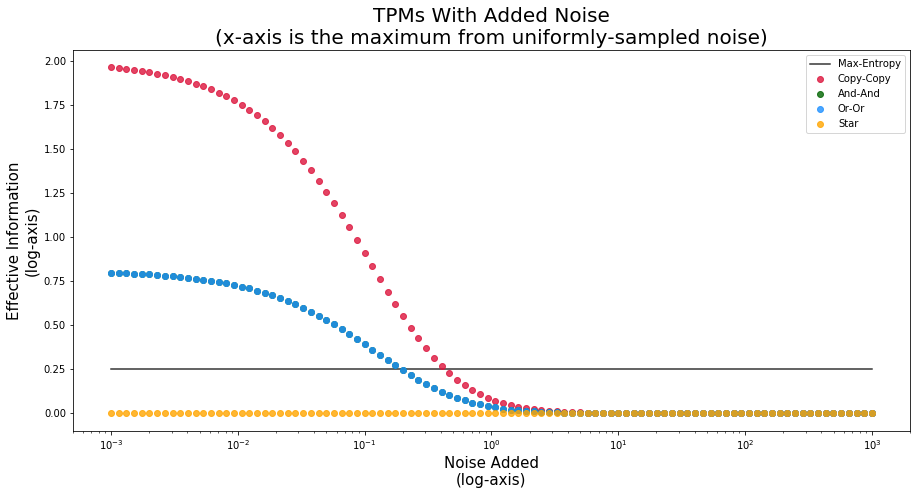

In [14]:
plt.figure(figsize=(15,7))
plt.plot(EIstar.keys(), [.25]*num, color='black', alpha=0.8, label='Max-Entropy')
plt.plot(EIcopy.keys(), EIcopy.values(), marker='o', linestyle='none', color='crimson', alpha=0.8, label='Copy-Copy')
plt.plot(EIand.keys(), EIand.values(), marker='o', linestyle='none', color='darkgreen', alpha=0.8, label='And-And')
plt.plot(EIor.keys(), EIor.values(), marker='o', linestyle='none', color='dodgerblue', alpha=0.8, label='Or-Or')
plt.plot(EIstar.keys(), EIstar.values(), marker='o', linestyle='none', color='orange', alpha=0.8, label='Star')
plt.title("TPMs With Added Noise\n(x-axis is the maximum from uniformly-sampled noise)", size=20)
plt.xlabel("Noise Added\n(log-axis)", size=15)
plt.xscale('log')
plt.ylabel("Effective Information\n(log-axis)", size=15)
plt.legend()
#plt.savefig("TPMS_Noise.png", dpi=300, bbox_inches='tight')
plt.show()

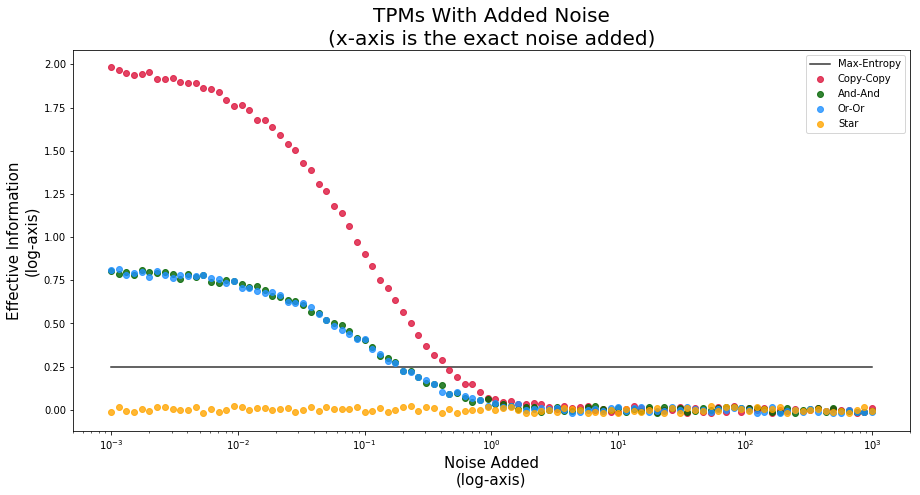

In [109]:
dodge0=np.random.uniform(low=-0.02, high=0.02, size=num)
dodge1=np.random.uniform(low=-0.02, high=0.02, size=num)
dodge2=np.random.uniform(low=-0.02, high=0.02, size=num)
dodge3=np.random.uniform(low=-0.02, high=0.02, size=num)
plt.figure(figsize=(15,7))
plt.plot(EIstar.keys(), [.25]*num, color='black', alpha=0.8, label='Max-Entropy')
plt.plot(EIcopy.keys(), np.array(list(EIcopy.values()))+dodge0, marker='o', linestyle='none', color='crimson', alpha=0.8, label='Copy-Copy')
plt.plot(EIand.keys(), np.array(list(EIand.values()))+dodge1, marker='o', linestyle='none', color='darkgreen', alpha=0.8, label='And-And')
plt.plot(EIor.keys(), np.array(list(EIor.values()))+dodge2, marker='o', linestyle='none', color='dodgerblue', alpha=0.8, label='Or-Or')
plt.plot(EIstar.keys(), np.array(list(EIstar.values()))+dodge3, marker='o', linestyle='none', color='orange', alpha=0.8, label='Star')
plt.title("TPMs With Added Noise\n(x-axis is the exact noise added)", size=20)
plt.xlabel("Noise Added\n(log-axis)", size=15)
plt.xscale('log')
plt.ylabel("Effective Information\n(log-axis)", size=15)
plt.legend()
#plt.savefig("TPMS_ExactNoise.png", dpi=300, bbox_inches='tight')
plt.show()

In [110]:
def plot_four_TPMS(tpm0, tpm1, tpm2, tpm3, labels=[], save=False):
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(17,4))
    ax0.imshow(tpm0, cmap="magma_r")
    ax1.imshow(tpm1, cmap="magma_r")
    ax2.imshow(tpm2, cmap="magma_r")
    ax3.imshow(tpm3, cmap="magma_r")

    if labels:
        ax0.set_title(labels[0], size=15)
        ax1.set_title(labels[1], size=15)
        ax2.set_title(labels[2], size=15)
        ax3.set_title(labels[3], size=15)

    else:
        ax0.set_title("Copy-Copy\n", size=15)
        ax1.set_title("And-And\n", size=15)
        ax2.set_title("Or-Or\n", size=15)
        ax3.set_title("Star\n", size=15)
    
    ax0.set_xticks(np.arange(0, 4, 1));
    ax0.set_yticks(np.arange(0, 4, 1));
    ax0.set_xticklabels(np.arange(0, 4, 1));
    ax0.set_yticklabels(np.arange(0, 4, 1));
    ax0.set_xticks(np.arange(-.5, 3.5, 1), minor=True);
    ax0.set_yticks(np.arange(-.5, 3.5, 1), minor=True);
    ax0.grid(which='minor', color='w', linestyle='-', linewidth=3)
    ax0.xaxis.tick_top()

    ax1.set_xticks(np.arange(0, 4, 1));
    ax1.set_yticks(np.arange(0, 4, 1));
    ax1.set_xticklabels(np.arange(0, 4, 1));
    ax1.set_yticklabels(np.arange(0, 4, 1));
    ax1.set_xticks(np.arange(-.5, 3.5, 1), minor=True);
    ax1.set_yticks(np.arange(-.5, 3.5, 1), minor=True);
    ax1.grid(which='minor', color='w', linestyle='-', linewidth=3)
    ax1.xaxis.tick_top()

    ax2.set_xticks(np.arange(0, 4, 1));
    ax2.set_yticks(np.arange(0, 4, 1));
    ax2.set_xticklabels(np.arange(0, 4, 1));
    ax2.set_yticklabels(np.arange(0, 4, 1));
    ax2.set_xticks(np.arange(-.5, 3.5, 1), minor=True);
    ax2.set_yticks(np.arange(-.5, 3.5, 1), minor=True);
    ax2.grid(which='minor', color='w', linestyle='-', linewidth=3)
    ax2.xaxis.tick_top()

    ax3.set_xticks(np.arange(0, 4, 1));
    ax3.set_yticks(np.arange(0, 4, 1));
    ax3.set_xticklabels(np.arange(0, 4, 1));
    ax3.set_yticklabels(np.arange(0, 4, 1));
    ax3.set_xticks(np.arange(-.5, 3.5, 1), minor=True);
    ax3.set_yticks(np.arange(-.5, 3.5, 1), minor=True);
    ax3.grid(which='minor', color='w', linestyle='-', linewidth=3)
    ax3.xaxis.tick_top()

    if save:
        plt.savefig("FourSampleTPMS.png", dpi=300, bbox_inches='tight')
    plt.show()

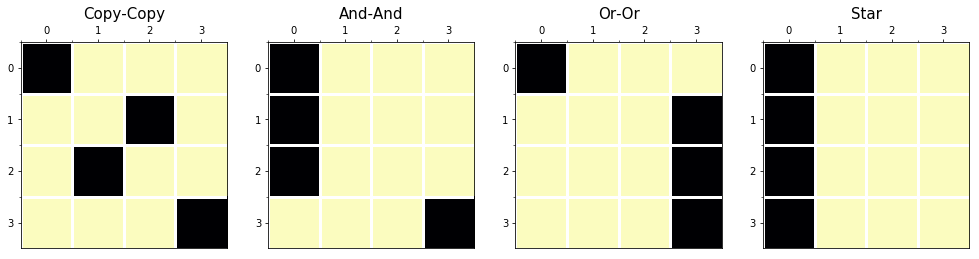

In [111]:
labels=["Copy-Copy\n", "And-And\n", "Or-Or\n", "Star\n"]
save = False
plot_four_TPMS(define_TPM("copycopy"), define_TPM("andand"), define_TPM("oror"), define_TPM("star"), labels, save)

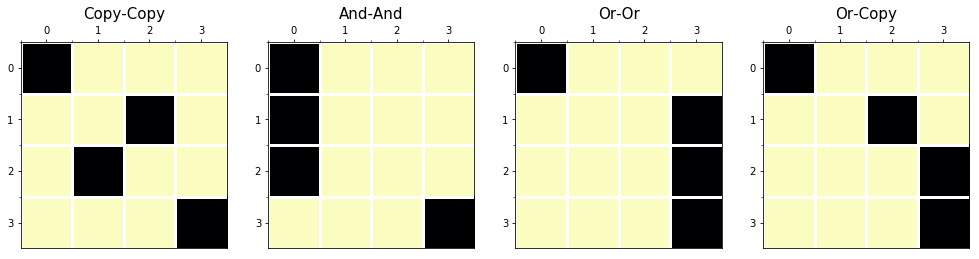

In [112]:
A = np.array([[1.0,0,0,0],[0,0,1.0,0],[0,0,0,1.0],[0,0,0,1.0]])
labels=["Copy-Copy\n", "And-And\n", "Or-Or\n", "Or-Copy\n"]
save = False
plot_four_TPMS(define_TPM("copycopy"), define_TPM("andand"), define_TPM("oror"), A, labels, save)

# 4. Comparing Algorithm Speeds

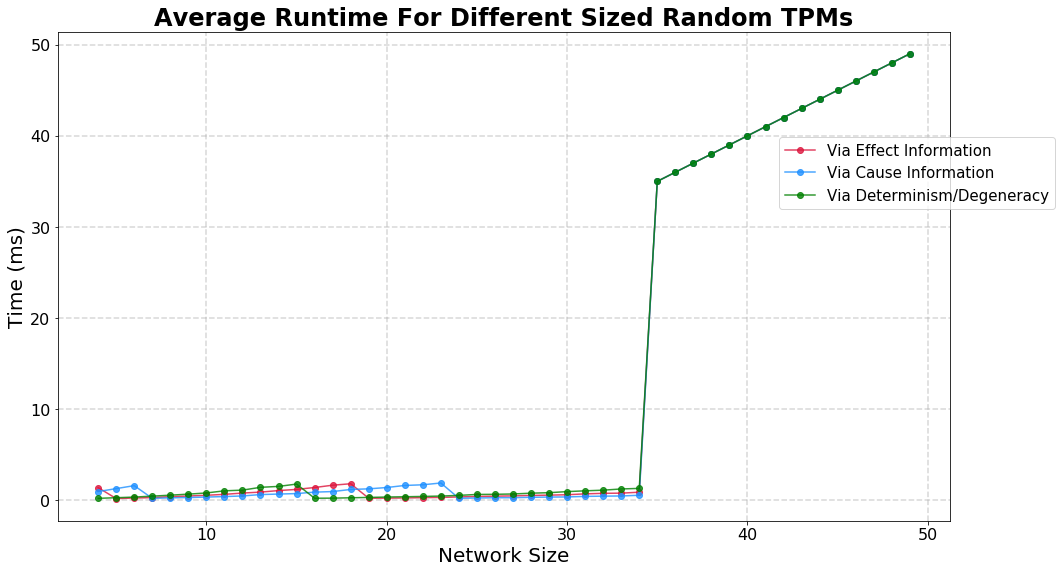

In [122]:
# maxN = 50
# ns = range(4,maxN)
# times = ns
# time_dictEI = dict(zip(ns, times))
# time_dictCI = dict(zip(ns, times))
# time_dictDD = dict(zip(ns, times))

# for n in ns:
#     pp = np.random.rand(n,n)
#     timeitsEI = %timeit -o get_EInet_EI(pp)
#     timeitsCI = %timeit -o get_EInet_CI(pp)
#     timeitsDD = %timeit -o get_EInet_DD(pp)
#     time_dictEI[n] = np.mean(timeitsEI.all_runs)
#     time_dictCI[n] = np.mean(timeitsCI.all_runs)
#     time_dictDD[n] = np.mean(timeitsDD.all_runs)

plt.figure(figsize=(16,9))
plt.plot(list(time_dictEI.keys())[:165], list(time_dictEI.values())[:165], marker='o', linestyle='-', 
         color='crimson', alpha=0.8, label='Via Effect Information')
plt.plot(list(time_dictCI.keys())[:165], list(time_dictCI.values())[:165], marker='o', linestyle='-', 
         color='dodgerblue', alpha=0.8, label='Via Cause Information')
plt.plot(list(time_dictDD.keys())[:165], list(time_dictDD.values())[:165], marker='o', linestyle='-', 
         color='green', alpha=0.8, label='Via Determinism/Degeneracy')

plt.xlabel("Network Size", size=20)
plt.ylabel("Time (ms)", size=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(bbox_to_anchor=[.8, .8], fontsize=15)#, title="Node ID")
plt.title("Average Runtime For Different Sized Random TPMs", size=24, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=1.5, alpha=0.5)
#plt.savefig("Runtime_by_N.png", dpi=300, bbox_inches='tight')
plt.show()

# 5. Testing the determinacy / degeneracy of differnt networks

In [203]:
N = 1000
m = 5
GBA = nx.barabasi_albert_graph(N, m)
k_ba = sum(list(dict(GBA.degree()).values()))/N
degreesBA = list(dict(GBA.degree()).values())
determsBA = np.array([get_determinism_net_i(GBA, i) for i in list(GBA.nodes())])
degenerBA = np.array([get_degeneracy_net_i( GBA, i) for i in list(GBA.nodes())])

p = k_ba / (N-1)
GER = nx.erdos_renyi_graph(N, p)
degreesER = list(dict(GER.degree()).values())
determsER = np.array([get_determinism_net_i(GER, i) for i in list(GER.nodes())])
degenerER = np.array([get_degeneracy_net_i( GER, i) for i in list(GER.nodes())])

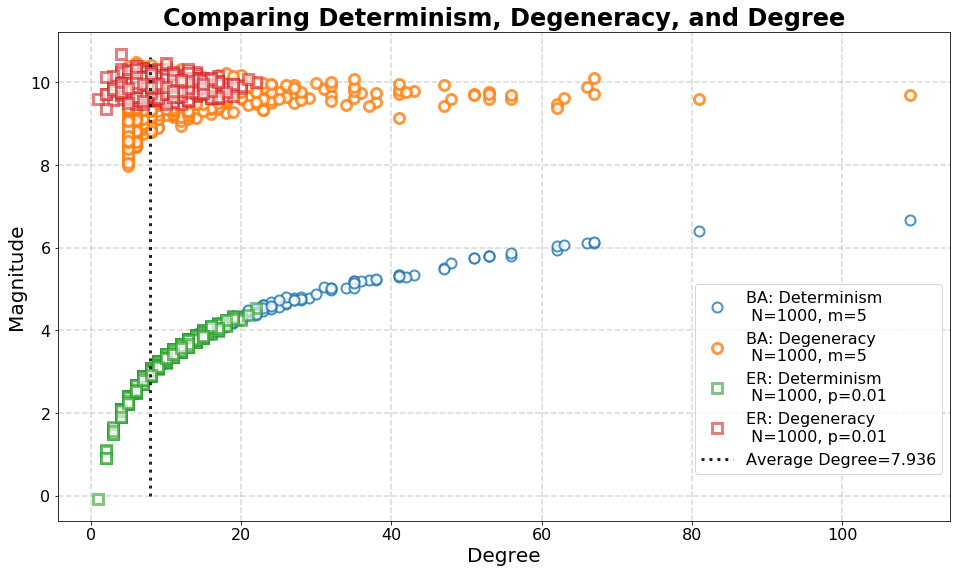

In [204]:
plt.figure(figsize=(16,9))
plt.plot(degreesBA, -determsBA+np.random.uniform(-.1,.1,1000), marker='o', 
    markersize=10.0, markerfacecolor='white', markeredgewidth=2, 
    linestyle='none', alpha=0.8, label='BA: Determinism \n N=1000, m=5')
plt.plot(degreesBA, -degenerBA+np.random.uniform(-.1,.1,1000), marker='o', 
    markersize=10.0, markerfacecolor='white', markeredgewidth=3, 
    linestyle='none', alpha=0.8, label='BA: Degeneracy \n N=1000, m=5')
plt.plot(degreesER, -determsER+np.random.uniform(-.1,.1,1000), marker='s', 
    markersize=10.0, markerfacecolor='white', markeredgewidth=3, 
    linestyle='none', alpha=0.6, label='ER: Determinism \n N=1000, p=0.01')
plt.plot(degreesER, -degenerER+np.random.uniform(-.1,.1,1000), marker='s', 
    markersize=10.0, markerfacecolor='white', markeredgewidth=3, 
    linestyle='none', alpha=0.6, label='ER: Degeneracy \n N=1000, p=0.01')
plt.plot([k_avg]*10, np.linspace(0, max(-degenerER), 10), color='black', linestyle=':', 
    linewidth=3, alpha=0.85, label='Average Degree=%.3f'%k_avg)

plt.xlabel("Degree", size=20)
plt.ylabel("Magnitude", size=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(bbox_to_anchor=[1.0, .5], fontsize=16)
plt.title("Comparing Determinism, Degeneracy, and Degree", size=24, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=1.5, alpha=0.5)
# plt.savefig("DeterminismDegeneracy_BA-ER.png", dpi=300, bbox_inches='tight')
plt.show()

In [205]:
diff1 = np.random.uniform(-0.15, 0.15, len(determsBA))
diff2 = np.random.uniform(-0.10, 0.10, len(determsBA))
diff3 = np.random.uniform(-0.15, 0.15, len(determsER))
diff4 = np.random.uniform(-0.10, 0.10, len(determsER))

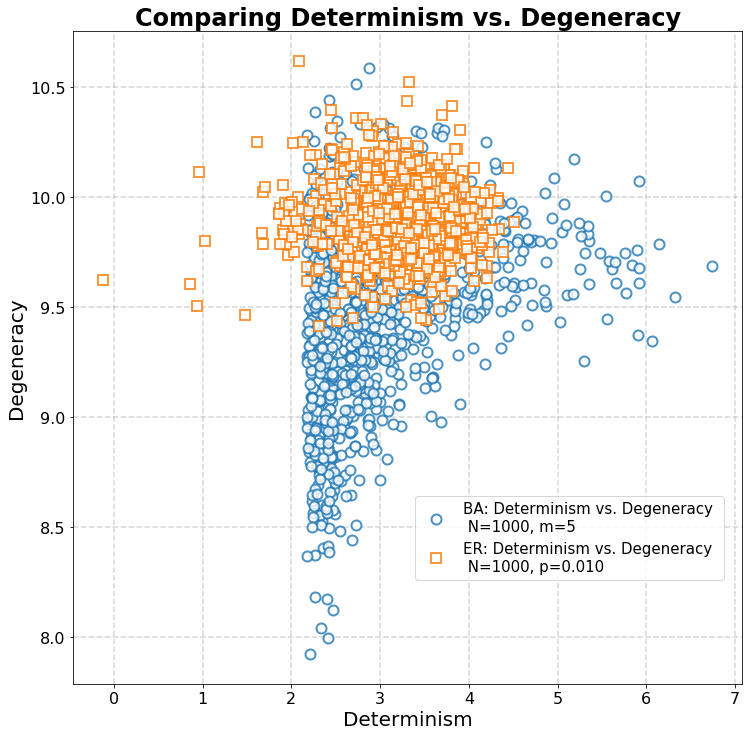

In [206]:
plt.figure(figsize=(12,12))
plt.plot(-determsBA+diff1, -degenerBA+diff2,
    marker='o', markersize=10.0, markerfacecolor='white', markeredgewidth=2,
    linestyle='none', alpha=0.8, label='BA: Determinism vs. Degeneracy \n N=%i, m=%i'%(N,m))
plt.plot(-determsER+diff3, -degenerER+diff4,
    marker='s', markersize=10.0, markerfacecolor='white', markeredgewidth=2,
    linestyle='none', alpha=0.8, label='ER: Determinism vs. Degeneracy \n N=%i, p=%.3f'%(N,p))

plt.xlabel("Determinism", size=20)
plt.ylabel("Degeneracy", size=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(bbox_to_anchor=[0.5, .3], fontsize=15)
plt.title("Comparing Determinism vs. Degeneracy", size=24, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=1.5, alpha=0.5)
# plt.savefig("Determinism_Degeneracy_BA-ER.png", dpi=300, bbox_inches='tight')
plt.show()

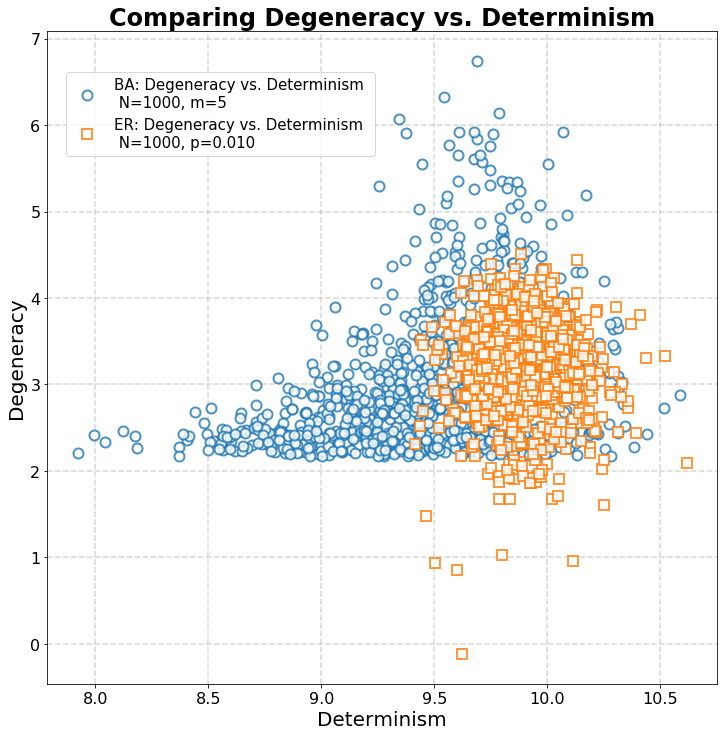

In [207]:
plt.figure(figsize=(12,12))
plt.plot(-degenerBA+diff2, -determsBA+diff1,
    marker='o', markersize=10.0, markerfacecolor='white', markeredgewidth=2,
    linestyle='none', alpha=0.8, label='BA: Degeneracy vs. Determinism \n N=%i, m=%i'%(N,m))
plt.plot(-degenerER+diff4, -determsER+diff3,
    marker='s', markersize=10.0, markerfacecolor='white', markeredgewidth=2,
    linestyle='none', alpha=0.8, label='ER: Degeneracy vs. Determinism \n N=%i, p=%.3f'%(N,p))

plt.xlabel("Determinism", size=20)
plt.ylabel("Degeneracy", size=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(bbox_to_anchor=[0.5, .95], fontsize=15)
plt.title("Comparing Degeneracy vs. Determinism", size=24, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=1.5, alpha=0.5)
# plt.savefig("Determinism_Degeneracy_BA-ER.png", dpi=300, bbox_inches='tight')
plt.show()

In [208]:
GBA_np = np.array(nx.to_numpy_matrix(GBA))
GER_np = np.array(nx.to_numpy_matrix(GER))
print("\tEffective Information (DD): \t", np.round(get_EInet_DD(GBA_np), 6))
print("\tEffective Information (EI): \t", np.round(get_EInet_EI(GBA_np), 6))
print("\tEffective Information (CI): \t", np.round(get_EInet_CI(GBA_np), 6))
print(" ")
print("\tEffective Information (DD): \t", np.round(get_EInet_DD(GER_np), 6))
print("\tEffective Information (EI): \t", np.round(get_EInet_EI(GER_np), 6))
print("\tEffective Information (CI): \t", np.round(get_EInet_CI(GER_np), 6))

	Effective Information (DD): 	 6.481411
	Effective Information (EI): 	 6.481411
	Effective Information (CI): 	 6.544846
 
	Effective Information (DD): 	 6.651952
	Effective Information (EI): 	 6.651952
	Effective Information (CI): 	 6.637964


# Plotting Networks

In [8]:
def get_communities(graph):
    """Wrapper for community detection algorithms."""
    return community.best_partition(graph)

def softmax(A, k=1.0):
    """Softmax vector normalization."""
    A = np.array(A) if not isinstance(A, np.ndarray) else A
    A = A * k
    A = np.exp(A - A.max())
    return A / np.sum(A)

def normalized(A):
    A = np.array(A) if not isinstance(A, np.ndarray) else A
    return [float(i)/sum(A) for i in A]

In [218]:
posBA = nx.spring_layout(GBA)
posER = nx.spring_layout(GER)
sample_factor = 2
edges_indexBA = np.random.choice(range(GBA.size()), size=int(GBA.size()/sample_factor), replace=False)
edges_indexER = np.random.choice(range(GER.size()), size=int(GER.size()/sample_factor), replace=False)
edgesBA = [list(GBA.edges())[e] for e in edges_indexBA]
edgesER = [list(GER.edges())[e] for e in edges_indexER]

In [224]:
cmap=plt.get_cmap('magma')
effect_infoBA = np.array([get_effectInfo_net_i(GBA, i) for i in list(GBA.nodes())])
effect_infoER = np.array([get_effectInfo_net_i(GER, i) for i in list(GER.nodes())])
effect_infoBA = effect_infoBA/max(effect_infoBA)
effect_infoER = effect_infoER/max(effect_infoER)
# effect_infoBA = softmax(effect_infoBA)
# effect_infoER = softmax(effect_infoER)
colors_nodesBA = cmap(effect_infoBA)
colors_nodesER = cmap(effect_infoER)

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(31,15))
nx.draw_networkx_nodes(GBA, posBA, linewidths=1.0, node_color=colors_nodesBA, alpha=0.7, ax=ax0).set_edgecolor('w')
nx.draw_networkx_edges(GBA, posBA, edgelist=edgesBA, width=.50, edge_color='darkgrey', alpha=0.8, ax=ax0)
ax0.axis("off")
ax0.set_title("BA Network", size=36, fontweight='bold')

nx.draw_networkx_nodes(GER, posER, linewidths=1.0, node_color=colors_nodesER, alpha=0.7, ax=ax1).set_edgecolor('w')
nx.draw_networkx_edges(GER, posER, edgelist=edgesER, width=.50, edge_color='darkgrey', alpha=0.8, ax=ax1)
ax1.axis("off")
ax1.set_title("ER Network", size=36, fontweight='bold')

plt.show()
# plt.savefig("BAERnet_NodesEI.png", dpi=300, bbox_inches='tight')

# Plot EI for BA & ER EI for different average degree along the x axis

In [282]:
def rewire_edges(G, frac=0.1):
    """
    Inputs: a graph object, the percentage of rewirings you want
    Output: the same graph object with some noisy edges
    """
    N = G.number_of_nodes()
    indices = np.random.choice(range(G.number_of_edges()), int(N*frac))
    edges = [list(G.edges())[e] for e in indices]
    
    # now switcheroo
    for edge in edges:
        if edge in G.edges():
            i, j = edge
            neigh = list(G.neighbors(i))
            new_j = np.random.choice(list(set(range(N))-set(neigh)-set([i])))
            G.remove_edge(i,j)
            G.add_edge(i,new_j)
    
    return G

In [ ]:
# 40 networks, some with fracnoise
ms = range(1,40)
N = 500
EI_BA0 = {}
EI_ER0 = {}
EI_BA1 = {}
EI_ER1 = {}
frac = 0.1

for m in ms:
    ba = nx.barabasi_albert_graph(N, m)
    kba_avg = sum(list(dict(ba.degree()).values()))/N
    p = kba_avg / (N-1)
    er = nx.erdos_renyi_graph(N, p)
    ker_avg = sum(list(dict(er.degree()).values()))/N
    EI_BA0[kba_avg] = get_EInet_EI(ba)
    EI_ER0[ker_avg] = get_EInet_EI(er)
    
    # with added noise
    ba = nx.barabasi_albert_graph(N, m)
    ba = rewire_edges(ba, frac)
    kba_avg = sum(list(dict(ba.degree()).values()))/N
    p = kba_avg / (N-1)
    er = nx.erdos_renyi_graph(N, p)
    er = rewire_edges(er, frac)
    ker_avg = sum(list(dict(er.degree()).values()))/N
    EI_BA1[kba_avg] = get_EInet_EI(ba)
    EI_ER1[ker_avg] = get_EInet_EI(er)
    
#     print("Done with:", m)

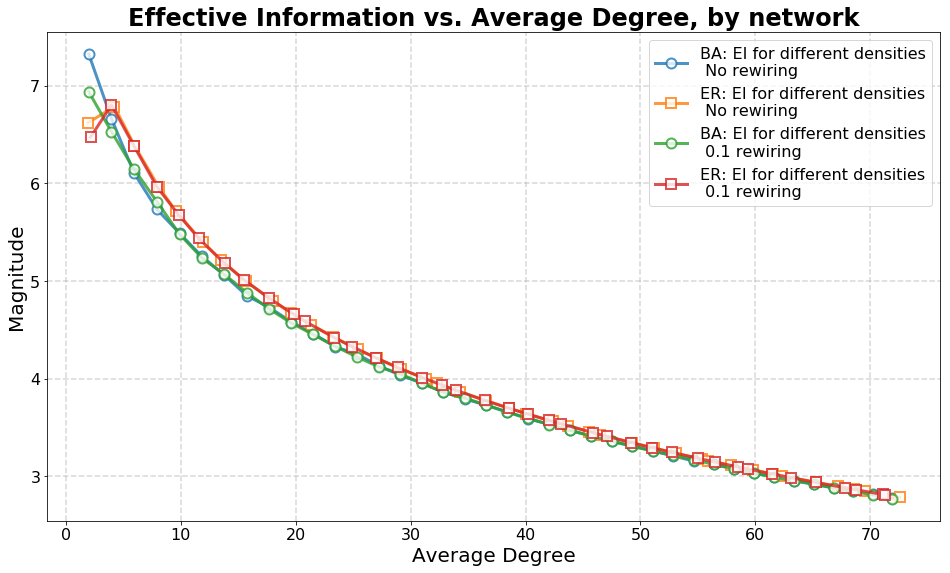

In [289]:
ba_degree0 = list(EI_BA0.keys())
ba_degree1 = list(EI_BA1.keys())
er_degree0 = list(EI_ER0.keys())
er_degree1 = list(EI_ER1.keys())
ba_ei0 = list(EI_BA0.values())
ba_ei1 = list(EI_BA1.values())
er_ei0 = list(EI_ER0.values())
er_ei1 = list(EI_ER1.values())

plt.figure(figsize=(16,9))
plt.plot(ba_degree0, ba_ei0, marker='o', markersize=10.0, markerfacecolor='white', markeredgewidth=2, 
    linestyle='-', linewidth=3.0, alpha=0.8, label='BA: EI for different densities\n No rewiring')
plt.plot(er_degree0, er_ei0, marker='s', markersize=10.0, markerfacecolor='white', markeredgewidth=2, 
    linestyle='-', linewidth=3.0, alpha=0.8, label='ER: EI for different densities\n No rewiring')
plt.plot(ba_degree1, ba_ei1, marker='o', markersize=10.0, markerfacecolor='white', markeredgewidth=2, 
    linestyle='-', linewidth=3.0, alpha=0.8, label='BA: EI for different densities\n 0.1 rewiring')
plt.plot(er_degree1, er_ei1, marker='s', markersize=10.0, markerfacecolor='white', markeredgewidth=2, 
    linestyle='-', linewidth=3.0, alpha=0.8, label='ER: EI for different densities\n 0.1 rewiring')

plt.xlabel("Average Degree", size=20)
plt.ylabel("Magnitude", size=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)#,bbox_to_anchor=[1.0, .5])
plt.title("Effective Information vs. Average Degree, by network", size=24, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=1.5, alpha=0.5)
plt.savefig("BAERnet_EI_avgk.png", dpi=300, bbox_inches='tight')
#plt.show()

In [10]:
# Real Data
with gzip.open("Friendship-network_data_2013.csv.gz") as fin:
    G = nx.read_edgelist(fin)
    
G1 = G.copy()
for node in G1.nodes():
    G1.add_edge(node, np.random.choice(G1.nodes()))
    
G1 = nx.convert_node_labels_to_integers(G1)
ei = [get_effectInfo_net_i(G1, node_i) for node_i in G1.nodes()]

deleteedges = np.random.choice(range(G1.number_of_edges()), size=int(G1.number_of_nodes())-1)
deleteThese = np.array(G1.edges())[deleteedges]

for edge in deleteThese:
    if edge in G1.edges():
        G1.remove_edge(edge[0],edge[1])
        
colei = softmax(ei/max(ei))/max(softmax(ei/max(ei)))

# pos = nx.spring_layout(G1, k=1.2, iterations=800)
# pos = nx.spring_layout(G1, k=1.9, iterations=5000)
color_nodes = plt.cm.magma((colei-.4)/(max(colei)-.6))
plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=2, alpha=0.95).set_edgecolor('grey')
#nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=2).set_edgecolor('w')
nx.draw_networkx_edges(G1, pos, edge_color="gainsboro", width=2.55, alpha=0.98)
nx.draw_networkx_edges(G1, pos, edge_color="black", width=0.25, alpha=0.8)
plt.axis('off')
# plt.show()
# plt.savefig("SocioPatternsNetwork.png", dpi=300, bbox_inches='tight')

NameError: name 'G' is not defined

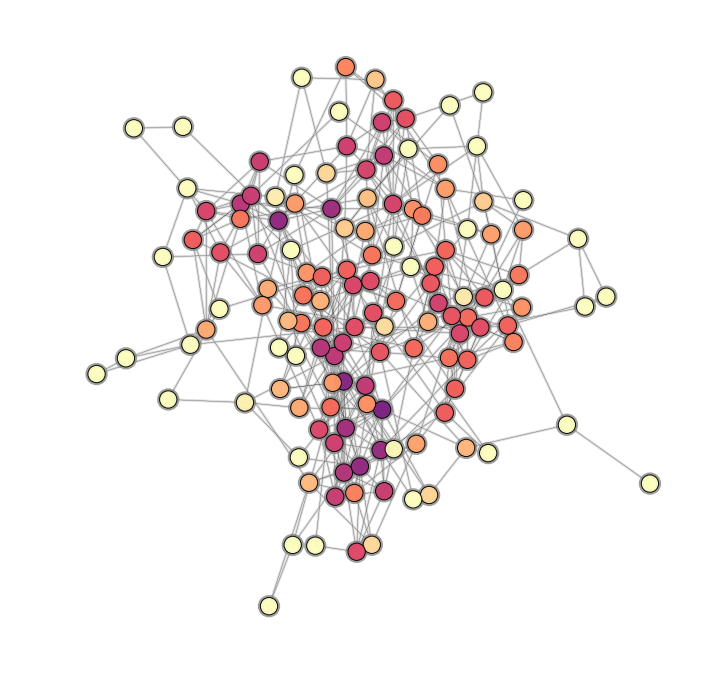

In [136]:
color_nodes = plt.cm.magma((colei-.4)/(max(colei)-.6))
plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=5, alpha=0.75).set_edgecolor('grey')
nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=1, alpha=0.95).set_edgecolor('k')
nx.draw_networkx_edges(G1, pos, edge_color="gainsboro", width=2.55, alpha=0.98)
nx.draw_networkx_edges(G1, pos, edge_color="black", width=0.25, alpha=0.8)
plt.axis('off')
plt.show()
# plt.savefig("SocioPatternsNetwork_effectinfo.png", dpi=425, bbox_inches='tight')

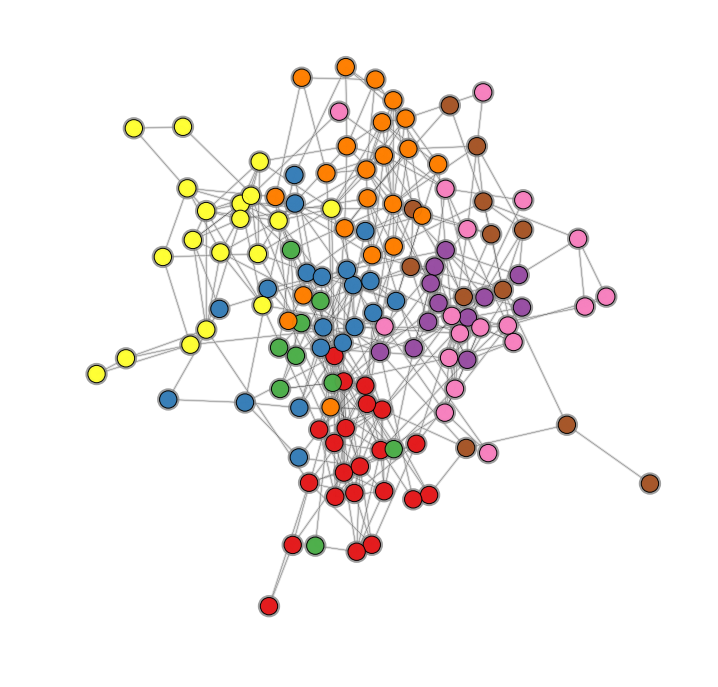

In [137]:
lv = community.best_partition(G1)
color_nodes = plt.cm.Set1(np.array(list(lv.values()))/(max(list(lv.values()))+1))

plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=5, alpha=0.75).set_edgecolor('grey')
nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=1, alpha=0.95).set_edgecolor('k')
nx.draw_networkx_edges(G1, pos, edge_color="gainsboro", width=2.55, alpha=0.98)
nx.draw_networkx_edges(G1, pos, edge_color="black", width=0.25, alpha=0.8)
plt.axis('off')
plt.show()
# plt.savefig("SocioPatternsNetwork_community.png", dpi=425, bbox_inches='tight')

In [ ]:
G1 = nx.complete_graph(100)

pos = nx.circular_layout(G1)
plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(G1, pos, node_color='gold', linewidths=3, alpha=0.95).set_edgecolor('grey')
nx.draw_networkx_nodes(G1, pos, node_color='gold', linewidths=1).set_edgecolor('k')
# nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=3, alpha=0.95).set_edgecolor('grey')
# nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=1).set_edgecolor('k')
nx.draw_networkx_edges(G1, pos, edge_color="gainsboro", width=0.25, alpha=0.98)
nx.draw_networkx_edges(G1, pos, edge_color="black", width=0.1, alpha=0.8)
plt.axis('off')
plt.show()
# plt.savefig("completegraph_example.png", dpi=425, bbox_inches='tight')

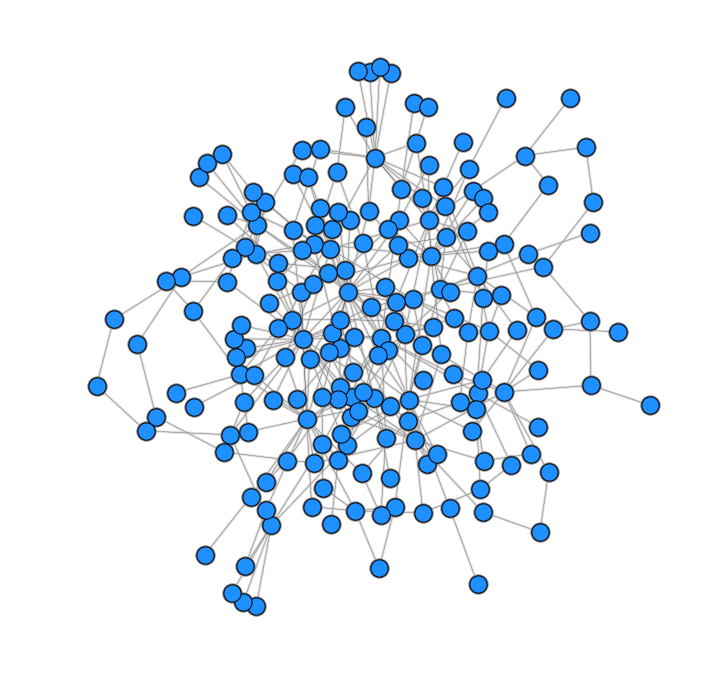

In [16]:
G1 = nx.barabasi_albert_graph(200,2)
for i in range(int(G1.number_of_edges()/5)):
    e = list(G1.edges())[np.random.choice(range(G1.number_of_edges()))]
    G1.remove_edge(e[0], e[1])
G1 = list(nx.connected_component_subgraphs(G1))[0]
pos = nx.spring_layout(G1, k=2.1, iterations=8000)
color_nodes = plt.cm.magma((colei-.45)/(max(colei)-.55))
plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(G1, pos, node_color='dodgerblue', linewidths=3, alpha=0.95).set_edgecolor('grey')
nx.draw_networkx_nodes(G1, pos, node_color='dodgerblue', linewidths=1).set_edgecolor('k')
nx.draw_networkx_edges(G1, pos, edge_color="gainsboro", width=2.55, alpha=0.98)
nx.draw_networkx_edges(G1, pos, edge_color="black", width=0.25, alpha=0.8)
plt.axis('off')
plt.show()
# plt.savefig("BA_example.png", dpi=425, bbox_inches='tight')

In [5]:
def fast_ei(G):
    """Returns the effective information of the network from effect information."""      
    if type(G)==np.ndarray:
        G = nx.from_numpy_matrix(G, create_using=nx.DiGraph())
    elif type(G)==nx.classes.graph.Graph:
        G = nx.DiGraph(G)
    
    A = nx.to_numpy_array(G)
    if not A.sum()==0:
        W_j = A.sum(axis=1)/A.sum()
        A = A[~np.all(A == 0, axis=1)]
        Wij = A/A.sum(axis=1)[:,None]
        N = Wij.shape[0]
        return sum([sp.stats.entropy(Wij[i], W_j, base=2) for i in range(N)])/G.number_of_nodes()

    else:
        return 0.0

In [13]:
print("BA")
G1 = nx.barabasi_albert_graph(200,2)
print(sum([get_degeneracy_net_i(G1, i) for i in G1.nodes()])/G1.number_of_nodes())
print(sum([get_determinism_net_i(G1, i) for i in G1.nodes()])/G1.number_of_nodes())
print(get_EInet_DD(G1))
print((fast_ei(G1)))

print("Ring")
G1 = nx.watts_strogatz_graph(200,2,0)
print(sum([get_degeneracy_net_i(G1, i) for i in G1.nodes()])/G1.number_of_nodes())
print(sum([get_determinism_net_i(G1, i) for i in G1.nodes()])/G1.number_of_nodes())
print(get_EInet_DD(G1))
print((fast_ei(G1)))

print("Star")
G1 = nx.star_graph(200)
print(sum([get_degeneracy_net_i(G1, i) for i in G1.nodes()])/G1.number_of_nodes())
print(sum([get_determinism_net_i(G1, i) for i in G1.nodes()])/G1.number_of_nodes())
print(get_EInet_DD(G1))
print((fast_ei(G1)))

print("ER")
G1 = nx.erdos_renyi_graph(200,0.01)
print(sum([get_degeneracy_net_i(G1, i) for i in G1.nodes()])/G1.number_of_nodes())
print(sum([get_determinism_net_i(G1, i) for i in G1.nodes()])/G1.number_of_nodes())
print(get_EInet_DD(G1))
print((fast_ei(G1)))


BA
-7.003166580919762
-1.6484031560066956
5.266859815279548
5.354763424913066
Ring
-7.643856189774699
-1.0
6.64385618977471
6.64385618977471
Star
-1.038029135272511
-0.03802913527251115
0.04522463667670888
0.9999999999999999
ER
-6.654161428542568
-0.9505975080611546
6.38390586706088
5.7035639204814155


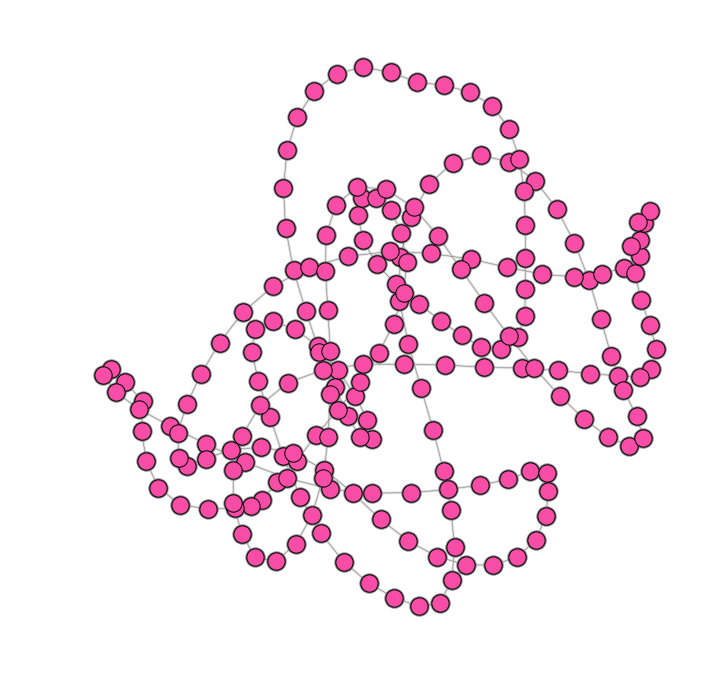

In [15]:
G1 = nx.watts_strogatz_graph(200, 2, 0.0)
ei = [get_effectInfo_net_i(G1, node_i) for node_i in G1.nodes()]
colei = softmax(ei/max(ei))/max(softmax(ei/max(ei)))
G1 = list(nx.connected_component_subgraphs(G1))[0]

pos = nx.spring_layout(G1)
# pos = nx.spring_layout(G1)#, k=2.1, iterations=8000)
# pos = nx.spring_layout(G1, k=1.9, iterations=5000)
color_nodes = plt.cm.magma((colei-.45)/(max(colei)-.55))
#color_nodes = plt.cm.magma(colei)
plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(G1, pos, node_color='#f84da7', linewidths=3, alpha=0.95).set_edgecolor('grey')
nx.draw_networkx_nodes(G1, pos, node_color='#f84da7', linewidths=1).set_edgecolor('k')
# nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=3, alpha=0.95).set_edgecolor('grey')
# nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=1).set_edgecolor('k')
nx.draw_networkx_edges(G1, pos, edge_color="gainsboro", width=2.55, alpha=0.98)
nx.draw_networkx_edges(G1, pos, edge_color="black", width=0.25, alpha=0.8)
plt.axis('off')
plt.show()
# plt.savefig("lattice_example.png", dpi=425, bbox_inches='tight')

In [121]:
G1 = nx.ring_of_cliques(5, 40)
# ei = [get_effectInfo_net_i(G1, node_i) for node_i in G1.nodes()]
print(get_EInet_EI(G1))

G2 = nx.watts_strogatz_graph(15, 2, 0.0)
print(get_EInet_EI(G2))



2.3566053210223523
2.9068905956085183


In [ ]:
pos1 = nx.spring_layout(G1)

nx.draw_networkx_nodes(G1, pos, node_color='#f07b00', linewidths=3, alpha=0.95).set_edgecolor('grey')
nx.draw_networkx_nodes(G1, pos, node_color='#f07b00', linewidths=1).set_edgecolor('k')
# nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=3, alpha=0.95).set_edgecolor('grey')
# nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=1).set_edgecolor('k')
nx.draw_networkx_edges(G1, pos, edge_color="gainsboro", width=2.55, alpha=0.98)
nx.draw_networkx_edges(G1, pos, edge_color="black", width=0.25, alpha=0.8)
plt.axis('off')


In [124]:
base = 1000
macro = 4000
G2_sizes = [base, macro]*int(G2.number_of_nodes()/2)
G2_colors = ['dodgerblue', "orange"]*int(G2.number_of_nodes()/2)

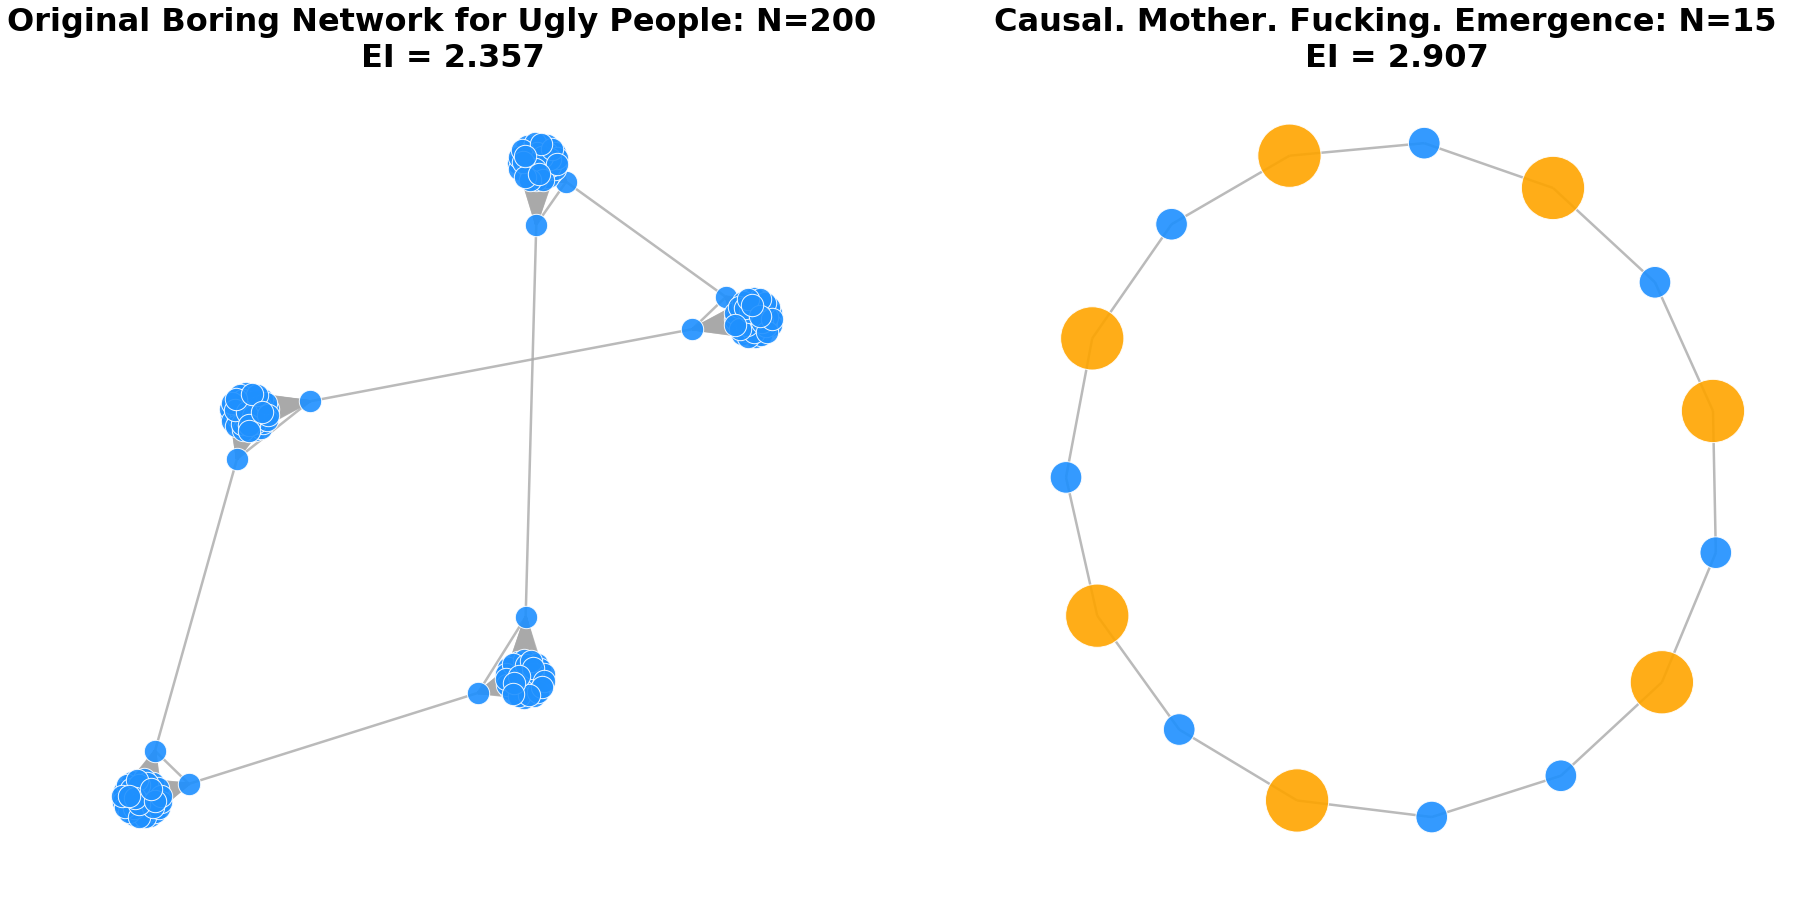

In [126]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(31,15))
pos1 = nx.spring_layout(G1, iterations=1500)
pos2 = nx.spring_layout(G2, iterations=500)
# pos1 = nx.spring_layout(G1)
# pos2 = nx.spring_layout(G2)

nx.draw_networkx_nodes(G1, pos1, linewidths=1.0, node_color='dodgerblue', node_size=base/2,
                       alpha=0.9, ax=ax0).set_edgecolor('w')
nx.draw_networkx_edges(G1, pos1, width=2.50, edge_color='darkgrey', alpha=0.8, ax=ax0)
ax0.axis("off")
ax0.set_title("Original Boring Network for Ugly People: N=200 \n EI = %.3f"%get_EInet_EI(G1), size=32, fontweight='bold')

nx.draw_networkx_nodes(G2, pos2, linewidths=1.0, node_color=G2_colors, node_size=G2_sizes,
                       alpha=0.9, ax=ax1).set_edgecolor('w')
nx.draw_networkx_edges(G2, pos2, width=2.50, edge_color='darkgrey', alpha=0.8, ax=ax1)
ax1.axis("off")
ax1.set_title("Causal. Mother. Fucking. Emergence: N=15 \n EI = %.3f"%get_EInet_EI(G2), size=32, fontweight='bold')

# plt.show()
plt.savefig("CausalEmergence_firstpass2.png", dpi=300, bbox_inches='tight')

In [119]:
np.log2(30) - np.log2(2)

3.9068905956085187

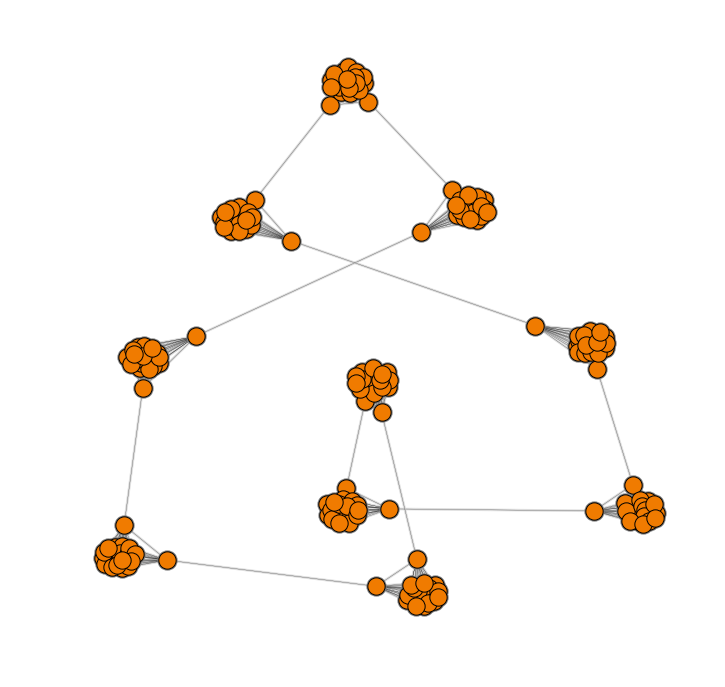

In [64]:
# G1 = nx.ring_of_cliques(10, 20)
# ei = [get_effectInfo_net_i(G1, node_i) for node_i in G1.nodes()]
# colei = softmax(ei/max(ei))/max(softmax(ei/max(ei)))
# G1 = list(nx.connected_component_subgraphs(G1))[0]

# pos = nx.spring_layout(G1)
# pos = nx.spring_layout(G1)#, k=2.1, iterations=8000)
# pos = nx.spring_layout(G1, k=1.9, iterations=5000)
color_nodes = plt.cm.magma((colei-.45)/(max(colei)-.55))
#color_nodes = plt.cm.magma(colei)
plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(G1, pos, node_color='#f07b00', linewidths=3, alpha=0.95).set_edgecolor('grey')
nx.draw_networkx_nodes(G1, pos, node_color='#f07b00', linewidths=1).set_edgecolor('k')
# nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=3, alpha=0.95).set_edgecolor('grey')
# nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=1).set_edgecolor('k')
nx.draw_networkx_edges(G1, pos, edge_color="gainsboro", width=2.55, alpha=0.98)
nx.draw_networkx_edges(G1, pos, edge_color="black", width=0.25, alpha=0.8)
plt.axis('off')
# plt.show()
# plt.savefig("ringofcliques_example.png", dpi=425, bbox_inches='tight')

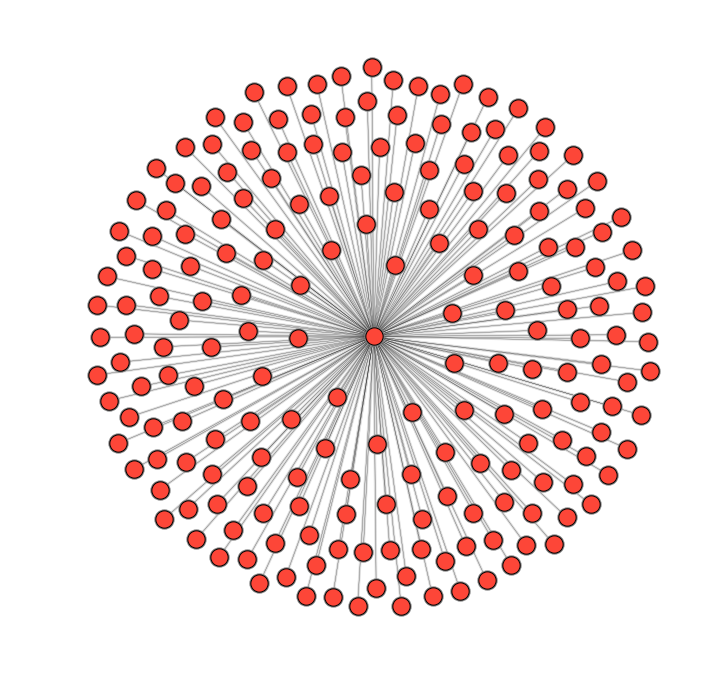

In [59]:
G1 = nx.star_graph(200)
# ei = [get_effectInfo_net_i(G1, node_i) for node_i in G1.nodes()]
# colei = softmax(ei/max(ei))/max(softmax(ei/max(ei)))
# G1 = list(nx.connected_component_subgraphs(G1))[0]

# pos = nx.spring_layout(G1)
pos = nx.spring_layout(G1)#, k=2.1, iterations=8000)
# pos = nx.spring_layout(G1, k=1.9, iterations=5000)
color_nodes = plt.cm.magma((colei-.45)/(max(colei)-.55))
#color_nodes = plt.cm.magma(colei)
plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(G1, pos, node_color='#fd4638', linewidths=3, alpha=0.95).set_edgecolor('grey')
nx.draw_networkx_nodes(G1, pos, node_color='#fd4638', linewidths=1).set_edgecolor('k')
# nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=3, alpha=0.95).set_edgecolor('grey')
# nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=1).set_edgecolor('k')
nx.draw_networkx_edges(G1, pos, edge_color="gainsboro", width=2.55, alpha=0.98)
nx.draw_networkx_edges(G1, pos, edge_color="black", width=0.25, alpha=0.8)
plt.axis('off')
plt.show()
# plt.savefig("star_example.png", dpi=425, bbox_inches='tight')

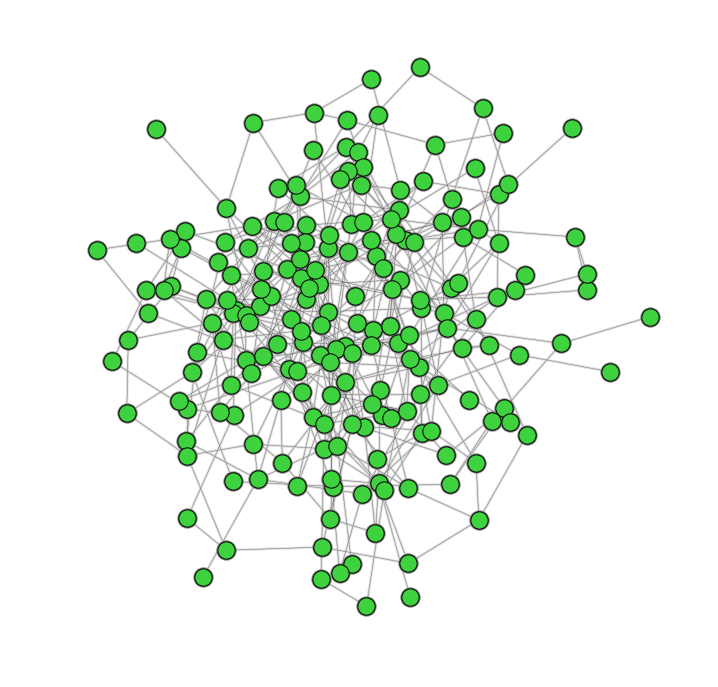

In [142]:
# G1 = nx.erdos_renyi_graph(200,0.02)
# ei = [get_effectInfo_net_i(G1, node_i) for node_i in G1.nodes()]
# colei = softmax(ei/max(ei))/max(softmax(ei/max(ei)))
# G1 = list(nx.connected_component_subgraphs(G1))[0]

# pos = nx.spring_layout(G1)
# pos = nx.spring_layout(G1)#, k=2.1, iterations=8000)
# pos = nx.spring_layout(G1, k=1.9, iterations=5000)
color_nodes = plt.cm.magma((colei-.45)/(max(colei)-.55))
#color_nodes = plt.cm.magma(colei)
plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(G1, pos, node_color='#3fd23f', linewidths=3, alpha=0.95).set_edgecolor('grey')
nx.draw_networkx_nodes(G1, pos, node_color='#3fd23f', linewidths=1).set_edgecolor('k')
# nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=3, alpha=0.95).set_edgecolor('grey')
# nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=1).set_edgecolor('k')
nx.draw_networkx_edges(G1, pos, edge_color="gainsboro", width=2.55, alpha=0.98)
nx.draw_networkx_edges(G1, pos, edge_color="black", width=0.25, alpha=0.8)
plt.axis('off')
# plt.show()
plt.savefig("ER_example.png", dpi=425, bbox_inches='tight')

In [ ]:
# G1 = nx.erdos_renyi_graph(200,0.01)
# ei = [get_effectInfo_net_i(G1, node_i) for node_i in G1.nodes()]
# colei = softmax(ei/max(ei))/max(softmax(ei/max(ei)))
# G1 = list(nx.connected_component_subgraphs(G1))[0]

# pos = nx.spring_layout(G1)
pos = nx.spring_layout(G1)#, k=2.1, iterations=8000)
# pos = nx.spring_layout(G1, k=1.9, iterations=5000)
color_nodes = plt.cm.magma((colei-.45)/(max(colei)-.55))
#color_nodes = plt.cm.magma(colei)
plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(G1, pos, node_color='#3fd23f', linewidths=3, alpha=0.95).set_edgecolor('grey')
nx.draw_networkx_nodes(G1, pos, node_color='#3fd23f', linewidths=1).set_edgecolor('k')
# nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=3, alpha=0.95).set_edgecolor('grey')
# nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=1).set_edgecolor('k')
nx.draw_networkx_edges(G1, pos, edge_color="gainsboro", width=2.55, alpha=0.98)
nx.draw_networkx_edges(G1, pos, edge_color="black", width=0.25, alpha=0.8)
plt.axis('off')
# plt.show()
plt.savefig("ER_example.png", dpi=425, bbox_inches='tight')

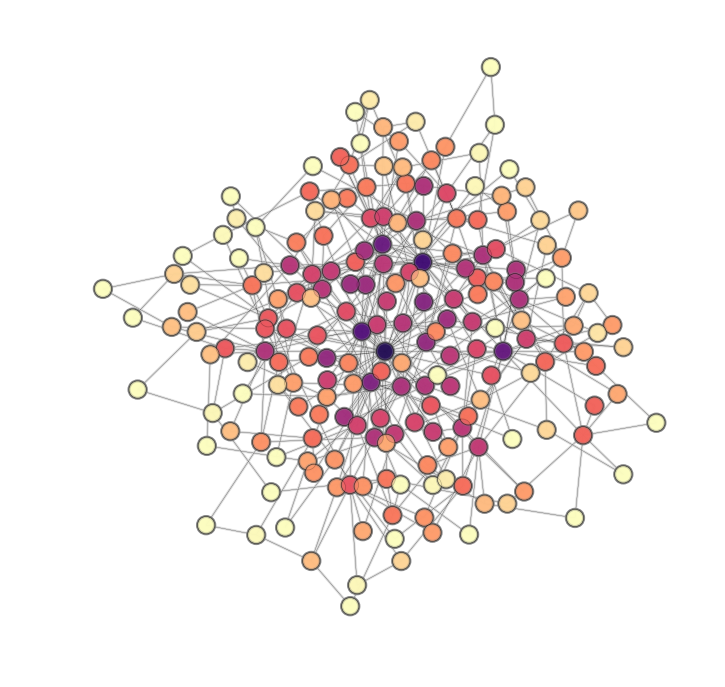

In [201]:
# G1 = nx.barabasi_albert_graph(200,2)
# ei = [get_effectInfo_net_i(G1, node_i) for node_i in G1.nodes()]
# colei = softmax(ei/max(ei))/max(softmax(ei/max(ei)))

# # pos = nx.spring_layout(G1)
# pos = nx.spring_layout(G1, k=2.1, iterations=8000)
# # pos = nx.spring_layout(G1, k=1.9, iterations=5000)
# color_nodes = plt.cm.magma((colei-.45)/(max(colei)-.55))
#color_nodes = plt.cm.magma(colei)
plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=3, alpha=0.95).set_edgecolor('grey')
nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=0.75, alpha=0.6).set_edgecolor('k')
nx.draw_networkx_edges(G1, pos, edge_color="gainsboro", width=2.55, alpha=0.98)
nx.draw_networkx_edges(G1, pos, edge_color="black", width=0.25, alpha=0.8)
plt.axis('off')
plt.show()
#plt.savefig("BAnet.png", dpi=425, bbox_inches='tight')
p = np.mean(list(dict(G1.degree()).values()))/G1.number_of_nodes()

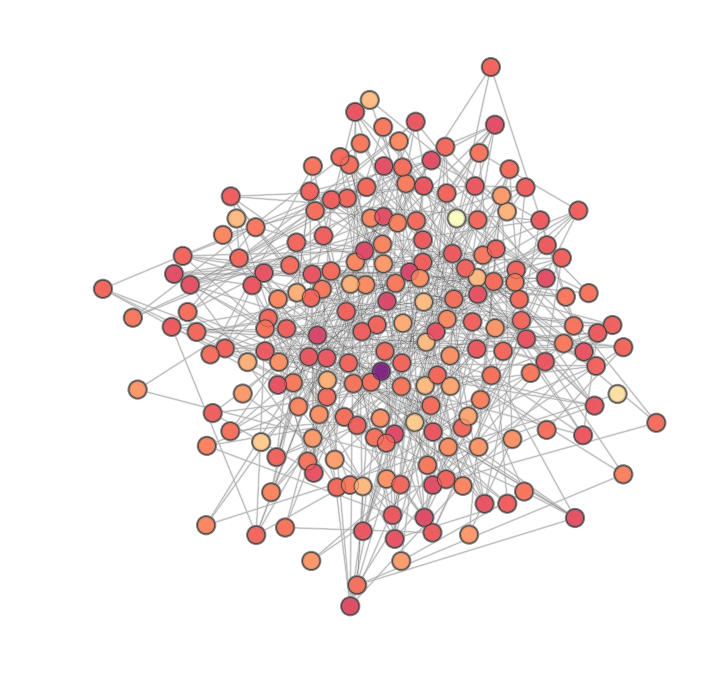

In [224]:
# N=200
# G1 = nx.erdos_renyi_graph(N,p)
# ei = [get_effectInfo_net_i(G1, node_i) for node_i in G1.nodes()]
# colei = softmax(ei/max(ei))/max(softmax(ei/max(ei)))

# pos = nx.spring_layout(G1)
# pos = nx.spring_layout(G1, k=2.1, iterations=8000)
# pos = nx.spring_layout(G1, k=1.9, iterations=5000)
# color_nodes = plt.cm.magma((colei-.2)/(max(colei)-.2))
# color_nodes = plt.cm.magma(colei)
plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=3, alpha=0.95).set_edgecolor('grey')
nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=0.75, alpha=0.6).set_edgecolor('k')
nx.draw_networkx_edges(G1, pos, edge_color="gainsboro", width=2.05, alpha=0.98)
nx.draw_networkx_edges(G1, pos, edge_color="black", width=0.15, alpha=0.8)
plt.axis('off')
# plt.show()
# plt.savefig("ERnet.png", dpi=425, bbox_inches='tight')

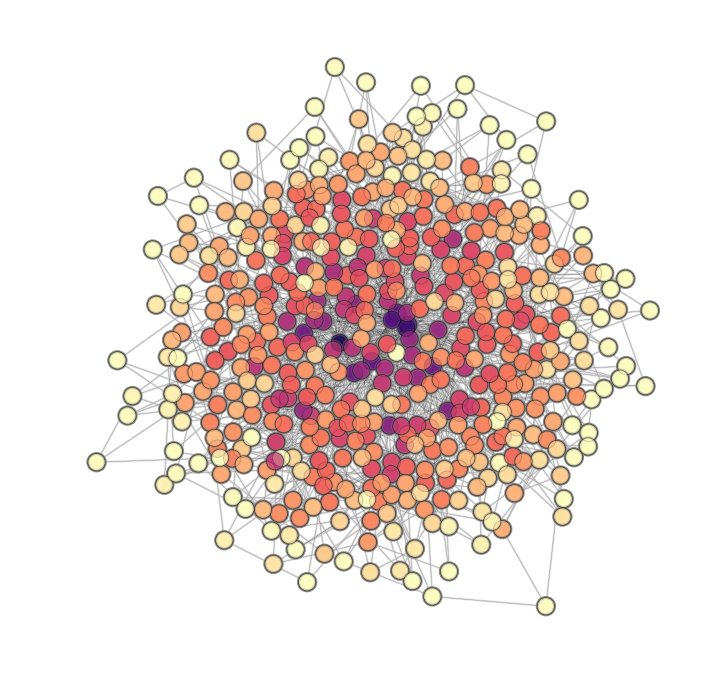

In [227]:
# N = 500
# G1 = nx.barabasi_albert_graph(N, 3)
# ei = [get_effectInfo_net_i(G1, node_i) for node_i in G1.nodes()]
# colei = softmax(ei/max(ei))/max(softmax(ei/max(ei)))

# # pos = nx.spring_layout(G1)
# pos = nx.spring_layout(G1, k=2.1, iterations=8000)
# # pos = nx.spring_layout(G1, k=1.9, iterations=5000)
# color_nodes = plt.cm.magma((colei-.45)/(max(colei)-.55))
# #color_nodes = plt.cm.magma(colei)
plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=3, alpha=0.95).set_edgecolor('grey')
nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=0.75, alpha=0.6).set_edgecolor('k')
nx.draw_networkx_edges(G1, pos, edge_color="gainsboro", width=2.05, alpha=0.98)
nx.draw_networkx_edges(G1, pos, edge_color="black", width=0.15, alpha=0.8)
plt.axis('off')
# plt.show()
plt.savefig("BAnet2.png", dpi=425, bbox_inches='tight')
p = np.mean(list(dict(G1.degree()).values()))/G1.number_of_nodes()

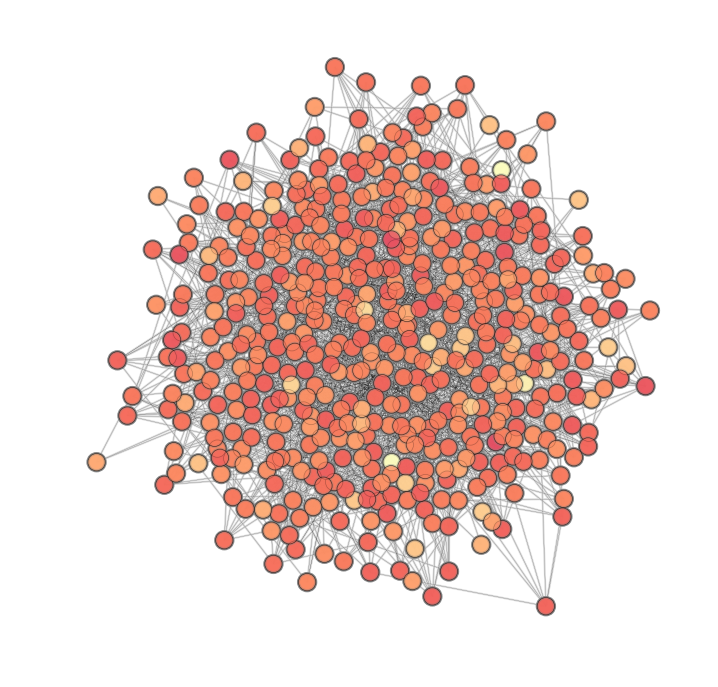

In [229]:
# G1 = nx.erdos_renyi_graph(N,p)
# ei = [get_effectInfo_net_i(G1, node_i) for node_i in G1.nodes()]
# colei = softmax(ei/max(ei))/max(softmax(ei/max(ei)))

# pos = nx.spring_layout(G1)
# pos = nx.spring_layout(G1, k=2.1, iterations=8000)
# pos = nx.spring_layout(G1, k=1.9, iterations=5000)
# color_nodes = plt.cm.magma((colei-.2)/(max(colei)-.2))
# color_nodes = plt.cm.magma(colei)
plt.figure(figsize=(12,12))
nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=3, alpha=0.95).set_edgecolor('grey')
nx.draw_networkx_nodes(G1, pos, node_color=color_nodes, linewidths=0.75, alpha=0.6).set_edgecolor('k')
nx.draw_networkx_edges(G1, pos, edge_color="gainsboro", width=2.05, alpha=0.98)
nx.draw_networkx_edges(G1, pos, edge_color="black", width=0.15, alpha=0.8)
plt.axis('off')
# plt.show()
plt.savefig("ERnet2.png", dpi=425, bbox_inches='tight')